# Limpieza

Nombres:

Maria Ontiveros A01197661

Samantha Bautista A01284462


## Reglas

0 - limpio, 

1 - sucio, 

2 - robot

1. Sí el cuarto esta sucio, el robot limpia.
2. El robot elije una direccion aleatoria entre sus celdas vecinas.
3. Si el robot elije la celda donde hay otro robot, no se mueve y permanece en la misma celda.

In [1]:
!python3 -m pip install mesa


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\Samantha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes. 

In [2]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model 

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [3]:
old_cmap = mlp.cm.get_cmap('viridis', 3)
colors = old_cmap(np.linspace(0, 1, 3))

colors[0] = np.array([250/256, 250/256, 250/256, 1]) # White
colors[1] = np.array([150/256, 150/256, 150/256, 1]) # Grey
colors[2] = np.array([0/256, 256/256, 0/256, 1]) # Green

# colors[0] = np.array([0/256, 256/256, 0/256, 1]) # Green
# colors[1] = np.array([256/256, 0/256, 0/256, 1]) # Red
# colors[2] = np.array([150/256, 150/256, 150/256, 1]) # Grey

# colors[3] = np.array([145/256, 94/256, 55/256, 1]) # Brown
# colors[4] = np.array([130/256, 130/256, 50/256, 1]) # Olive
# colors[5] = np.array([10/256, 100/256, 20/256, 1]) # Dark Green
#
# colors[6] = np.array([250/256, 250/256, 250/256, 1]) # White
# colors[7] = np.array([86/256, 102/256, 255/256, 1]) # Blue
# colors[8] = np.array([185/256, 89/256, 255/256, 1]) # Purple
# colors[9] = np.array([10/256, 10/256, 10/256, 1]) # Black
colormap = mlp.colors.ListedColormap(colors)

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [4]:
class GameLifeAgent(Agent):
    def __init__(self, unique_id, model, clean):
        super().__init__(unique_id, model)
        self.live = clean
        self.next_state = None
    
    def step(self):
        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)

        # live_neighbours = np.sum([neighbour.live for neighbour in neighbours])
        live_neighbours = 0
        neighbours_list = []
        for neighbor in neighbours:
            live_neighbours = live_neighbours + int(neighbor.live == 1)
            neighbours_list.append(int(neighbor.live == 1))

        self.next_state = self.live
        # if self.next_state == 0:
        #     self.next_state = np.random.choice(neighbours_list)
        # elif self.next_state == 1:
        #     self.next_state = np.random.choice([0,1,2], 1, p=[0.39, 0.6, 0.01])
    
    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.live = self.next_state
            
class GameLifeModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height, agents, dirty_cells):
        self.width = width
        self.height = height
        self.agents = agents
        self.dirty = dirty_cells
        self.time = time

        self.reset()



    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)
        self.cleaners = []

        for (content, x, y) in self.grid.coord_iter():
            if (x == 0 and y < self.agents):
              a = GameLifeAgent((x, y), self, 2)
              self.cleaners.append(a)
            else:
              a = GameLifeAgent((x, y), self, np.random.choice([0,1], p=[(1-dirty_cells),dirty_cells]))

            self.grid.place_agent(a, (x, y))
            self.schedule.add(a)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "Clean": self.get_clean,
                             "Dirty": self.get_dirty}
        )
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

        for x in self.cleaners:
          self.cleanerMoving = x
          self.move_agent()

    def get_grid(self):
        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            grid[x][y] = cell_content.live

        return grid

    def move_agent(self):
      x = 0
      y = 0

      x_original = self.cleanerMoving.unique_id[0]
      y_original = self.cleanerMoving.unique_id[1]

      while(x == 0 and y == 0):
        x = np.random.choice([-1,0,1])
        y = np.random.choice([-1,0,1])

      x_coor_cleaner = x_original + x
      y_coor_cleaner = y_original + y

      if (x_coor_cleaner == self.width):
        x_coor_cleaner = 0
      elif (x_coor_cleaner < 0):
        x_coor_cleaner = self.width-1

      if (y_coor_cleaner == self.height):
        y_coor_cleaner = 0
      elif (y_coor_cleaner < 0):
        y_coor_cleaner = self.height-1
      
      for cleaner in self.cleaners:
        if (cleaner.unique_id[0] == x_coor_cleaner and cleaner.unique_id[1] == y_coor_cleaner):
          print("No move")
          return

      for agent in self.schedule.agents:
        if(agent.unique_id == (x_coor_cleaner, y_coor_cleaner)):
          self.kill_agent = agent
          self.remove_agent()

          self.grid.remove_agent(self.cleanerMoving)

          self.cleanerMoving.unique_id = (x_coor_cleaner, y_coor_cleaner)
          self.grid.place_agent(self.cleanerMoving, (x_coor_cleaner, y_coor_cleaner))

          a = GameLifeAgent((x_original, y_original), self, 0)

          self.grid.place_agent(a, (x_original, y_original))
          #self.schedule.add(a)

          return


    def remove_agent(self):
      x = self.kill_agent

      self.grid.remove_agent(x)
      self.schedule.remove(x)

    def get_clean(self):
        total_live_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent):
                total_live_agents += int(agent.live==0)

        return total_live_agents

    def get_dirty(self):
        total_live_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent):
                total_live_agents += int(agent.live==1)

        return total_live_agents

# Ejecución del modelo
A continuación corremos el modelo

In [2]:
# Definimos el tamaño del Grid ..> 7 x 7
M = int(input("Columnas: "))
N = int(input("Filas: "))

dirty_cells = int(input("Porcentaje de celdas sucias: "))
dirty_cells = dirty_cells / 100

num_agents = 0

while (num_agents > M or num_agents < 1):
  num_agents = int(input("# de agentes: "))

# Definimos el número de generaciones a correr
max_time = int(input("Tiempo maximo en segundos: "))

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()
total_time = time.time() - start_time

model = GameLifeModel(M, N, num_agents, dirty_cells)
NUM_GENERATIONS = 0
dirty = model.get_dirty()

while (max_time > total_time and dirty > 0):
  model.step()
  total_time = time.time() - start_time
  NUM_GENERATIONS = NUM_GENERATIONS + 1
  dirty = model.get_dirty()

if(dirty == 0):
    model.step()
    NUM_GENERATIONS = NUM_GENERATIONS + 1

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(total_time))))

NameError: name 'time' is not defined

Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [ ]:
all_grids = model.datacollector.get_model_vars_dataframe()

In [ ]:
model.get_grid()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 2.],
       [0., 2., 2., 0., 0.],
       [0., 0., 0., 2., 0.]])

Graficamos la información usando `matplotlib`

In [ ]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

patch_grid = axs.imshow(model.get_grid(), vmin=0, vmax=2, cmap=colormap)

cells_clean = []
cells_dirty = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])

    cells_clean.append(all_grids['Clean'].iloc[i])
    cells_dirty.append(all_grids['Dirty'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [ ]:
anim

# Gráfica de Tiempo

En la gráfica se observa como la cantidad de cuartos sucios disminuye entre cada step, hasta que finalmente todos los cuartos esten limpios. Al correr la simulación con más agentes, el tiempo de ejecución disminuyó considerablemente.

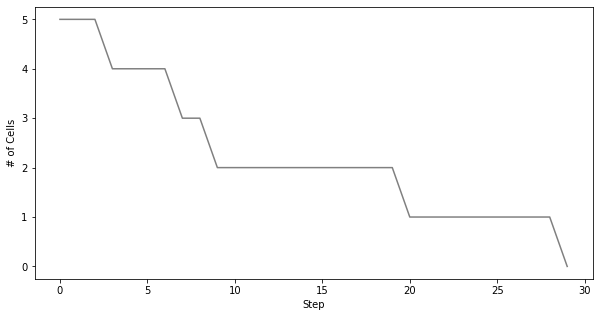

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("# of Cells")

plt.plot(cells_dirty, color='Gray')
plt.show()